# Case Study 4 : Data Science in NYC Taxi and Uber Data

**Required Readings:** 
* [Analyzing 1.1 Billion NYC Taxi and Uber Trips](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/) 
* Please download the NYC taxi and Uber dataset from [here](https://github.com/toddwschneider/nyc-taxi-data).
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Uber/Taxi Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Exploration: Exploring the Uber/Taxi Dataset

** plot the spatial distribution of the pickup locations of 5000 Uber trips** 
* collect a set of 5000 Uber trips
* plot the distribution of the pickup locations using a scatter plot figure.

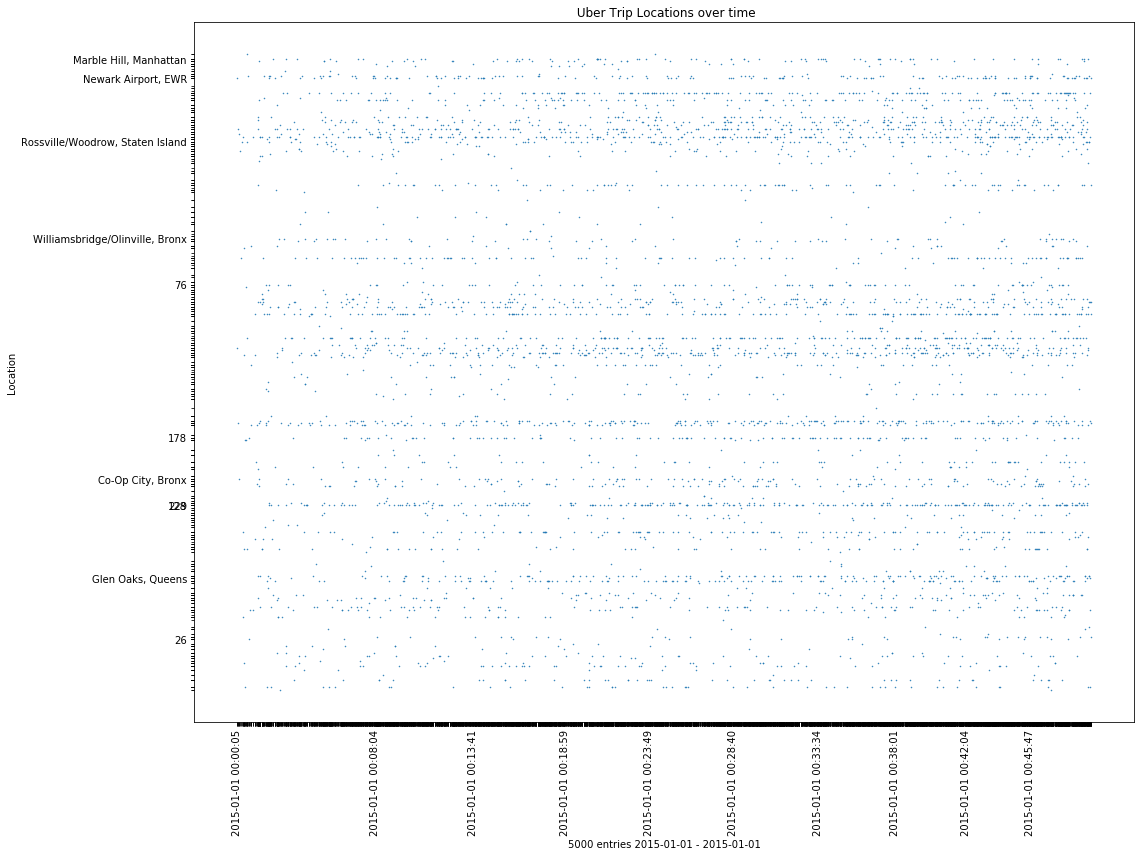

Location Legend
  Id  Zone
----  --------------------------------------------------------
   1  Newark Airport, EWR
   2  Jamaica Bay, Queens
   3  Allerton/Pelham Gardens, Bronx
   4  Alphabet City, Manhattan
   5  Arden Heights, Staten Island
   6  Arrochar/Fort Wadsworth, Staten Island
   7  Astoria, Queens
   8  Astoria Park, Queens
   9  Auburndale, Queens
  10  Baisley Park, Queens
  11  Bath Beach, Brooklyn
  12  Battery Park, Manhattan
  13  Battery Park City, Manhattan
  14  Bay Ridge, Brooklyn
  15  Bay Terrace/Fort Totten, Queens
  16  Bayside, Queens
  17  Bedford, Brooklyn
  18  Bedford Park, Bronx
  19  Bellerose, Queens
  20  Belmont, Bronx
  21  Bensonhurst East, Brooklyn
  22  Bensonhurst West, Brooklyn
  23  Bloomfield/Emerson Hill, Staten Island
  24  Bloomingdale, Manhattan
  25  Boerum Hill, Brooklyn
  26  Borough Park, Brooklyn
  27  Breezy Point/Fort Tilden/Riis Beach, Queens
  28  Briarwood/Jamaica Hills, Queens
  29  Brighton Beach, Brooklyn
  30  Broad Channel

In [8]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
import psycopg2
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt


def connectToNYCData(userName):
    """ Connection to the NYC Taxi Data in the local POSTGRES DB"""
    return psycopg2.connect('dbname=nyc-taxi-data user={0}'.format(userName))

def queryLocationTimeForUber(nycDBConn):
    """Query for location and Time as x and y axis values"""

    """we query for 5000 uber records for jan - feb 2015
       - location_id is our yaxis
       - epoch conversion is so we have an integer on the xaxis (time)
         we subtract 1420070405 from epoch to collapse our xaxis number to be more reasonable"""
    query = nycDBConn.cursor()
    numrows = query.execute("select location_id, pickup_datetime, location_id as yVal, (extract(epoch from pickup_datetime)::INT - 1420070405) as xVal\
    from uber_trips_2015\
    where extract(month from pickup_datetime) IN(1, 2)\
    order by pickup_datetime\
    limit 5000")
    yArray = np.array([], np.int32)
    xArray = np.array([], np.int32)
    xTicks = np.array([], np.dtype(str, 20))
    rows = query.fetchall()
    minDate = ''
    rowcount = 0
    for row in rows:
        yArray = np.append(yArray, [row[2]])
        xArray = np.append(xArray, [row[3]])
        if minDate == '':
            minDate = str(row[1].date())
        maxDate = str(row[1].date())
        tick = ''
        if 0 == rowcount % 500:
            tick = str(row[1])
        xTicks = np.append(xTicks, [tick])
        rowcount += 1
    query.close()
    return { 'xVals': xArray, 'yVals': yArray, 'xTicks': xTicks, 'minDate': minDate, 'maxDate': maxDate }

def queryLocationTableForUber(nycDBConn):
    """ LocationID -> human readable location for legend """
    query = nycDBConn.cursor()
    numrows = query.execute("SELECT DISTINCT A.location_id, B.ZONE || ', ' || B.borough as Location\
    FROM uber_trips_2015 A\
    INNER JOIN taxi_zone_lookups B ON B.location_id = A.location_id\
    ORDER BY A.location_id")
    rows = query.fetchall()
    locationNameData = None
    yTicks = np.array([], np.dtype(str, 50))
    rowcount = 0
    for row in rows:
        locationName = np.array([str(row[0]), row[1]], np.dtype(str, 50))
        if locationNameData is None:
            locationNameData = np.array([locationName])
        else:
            locationNameData = np.append(locationNameData, [locationName], axis=0)
        tick = ''
        if 0 == rowcount % 50:
            tick = row[1]
        elif 0 == rowcount % 25:
            tick = str(row[0])
        yTicks = np.append(yTicks, [tick])
        rowcount += 1
    query.close()
    return {'yTicks': yTicks, 'locationNameData': locationNameData, 'locationNameTitles': ['Id', 'Zone'] }

dbConn = connectToNYCData('lapage')
plotsxTicks = queryLocationTimeForUber (dbConn)
locationTable = queryLocationTableForUber(dbConn)
xvals = plotsxTicks['xVals']
yvals = plotsxTicks['yVals']

fig = plt.figure(figsize=(16, 12))
plt.scatter(xvals, yvals, marker='.', s=1)
plt.xticks(xvals, plotsxTicks['xTicks'], rotation='vertical')
plt.xlabel('{0} entries {1} - {2}'.format(str(xvals.size), plotsxTicks['minDate'], plotsxTicks['maxDate']))
plt.yticks(yvals, locationTable['yTicks'])
plt.ylabel('Location')
plt.title(' Uber Trip Locations over time')
fig.tight_layout()
plt.show()
print('Location Legend')
print(tabulate(locationTable['locationNameData'], headers=locationTable['locationNameTitles']))

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

Write codes to implement the solution in python:

In [2]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import json
import shapefile as shp  #pip install pyshp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def plotManhattanHeatMap(nycTaxiZoneSHP, title, fillColor, zoneValueDict):
    """Plot and render HeatMap of NYC Manhattan Borough Zone Weights"""
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.title('Manhattan {0}'.format(title))
    minValue = min(zoneValueDict.values())
    maxValue = max(zoneValueDict.values())
    topValue = maxValue - minValue;
    for shape in nycTaxiZoneSHP.shapeRecords():
        if shape.record[5] == 'Manhattan':
            fillPCT = 0.0
            if shape.record[3] in zoneValueDict:
                fillPCT = (zoneValueDict[shape.record[3]] - minValue)/topValue
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            plt.plot(x,y, color='black')
            plt.fill(x, y, color=fillColor, alpha=fillPCT)

def loadSolutionDataToMaps(solutionDataJsonFile):
    """Load all solution data into maps by dow -> tod -> taxiZone: taxiCount or fare/tip total or money total"""
    with open(solutionDataJsonFile) as data_file:
        data = json.load(data_file)
    taxiCountDict = {}
    fareTotalDict = {}
    tipTotalDict = {}
    moneyTotalDict = {}
    for dayIntervalZoneData in data:
        if dayIntervalZoneData['dow'] not in taxiCountDict:
            taxiCountDict[dayIntervalZoneData['dow']] = {}
            fareTotalDict[dayIntervalZoneData['dow']] = {}
            tipTotalDict[dayIntervalZoneData['dow']] = {}
            moneyTotalDict[dayIntervalZoneData['dow']] = {}
        if dayIntervalZoneData['tod'] not in taxiCountDict[dayIntervalZoneData['dow']]:
            taxiCountDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']] = {}
            fareTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']] = {}
            tipTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']] = {}
            moneyTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']] = {}
        if dayIntervalZoneData['taxizone'] not in taxiCountDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']]:
            taxiCountDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']][dayIntervalZoneData['taxizone']] = dayIntervalZoneData['taxi_count']
            fareTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']][dayIntervalZoneData['taxizone']] = dayIntervalZoneData['fare_total']
            tipTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']][dayIntervalZoneData['taxizone']] = dayIntervalZoneData['tip_total']
            moneyTotalDict[dayIntervalZoneData['dow']][dayIntervalZoneData['tod']][dayIntervalZoneData['taxizone']] = (dayIntervalZoneData['fare_total'] + dayIntervalZoneData['tip_total'])
    return { 'taxiCountMap': taxiCountDict, 'fareTotalMap': fareTotalDict, 'tipTotalMap': tipTotalDict, 'moneyTotal': moneyTotalDict}

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


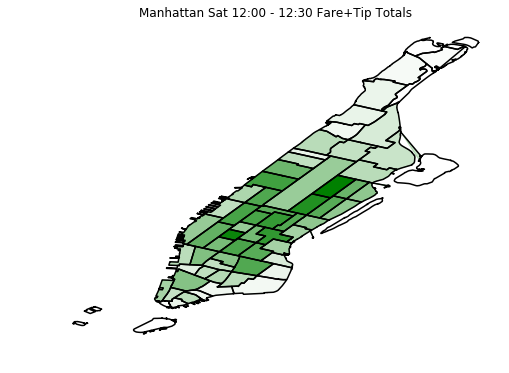

In [3]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

NYCTaxiZones = shp.Reader('./taxi_zones/taxi_zones.shp')
NYCDayIntervalZoneData = loadSolutionDataToMaps('./UsersCase4Team3SolutionDataManhattan.json')


plotManhattanHeatMap(NYCTaxiZones, 'Sat 12:00 - 12:30 Fare+Tip Totals', 'green', NYCDayIntervalZoneData['moneyTotal']['SAT']['12:00:00-12:30:00'])
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 4".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot the spatial distribution of the pickup locations of 5000 Uber trips (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


